** This notebook was taken from the original work of Pat Walters ([Some Thoughts on Splitting Chemical Datasets](https://practicalcheminformatics.blogspot.com/2024/11/some-thoughts-on-splitting-chemical.html)) and modified to include the new clustering algorithm [BitBIRCH](https://www.biorxiv.org/content/10.1101/2024.08.10.607459v1) from the work of the Miranda-Quintana Research Group.

A comparison of timing between the BitBIRCH and the Butina clustering methods has also been added. 

### Dataset Splitting
This notebook explores a few strategies for dataset splitting.  It also serves as a demonstration of some of the splitting capabilities in useful_rdkit_utils. 

In [1]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, AllChem
from rdkit.DataStructs import BulkTanimotoSimilarity, ExplicitBitVect
from rdkit.ML.Cluster import Butina
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from lgbm_wrapper import LGBMMorganCountWrapper
from sklearn.metrics import r2_score, mean_absolute_error
import itertools
import time
import bitbirch as bb

/home/kdavis2/mambaforge/envs/isim_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Read the Input Data
Here are two demo datasets.  The **biogen_logS** dataset contains the log of aqueous solubility for a diverse datasets.  The **Carbonic.smi** set is a more congeneric set of carbonic anyhydrase inhibitors. The file **biogen_logS.csv** is from [this paper](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160)  The file **Carbonic.smi** is from [this paper](https://pubs.acs.org/doi/10.1021/acs.jcim.8b00542). 

In [2]:
df = pd.read_csv("biogen_logS.csv")
#df = pd.read_csv("Carbonic.smi",sep=" ",names=["SMILES","Name","pIC50"])

#### Cluster the Data

In the next four cells we use functions from [useful_rdkit_utils](xxx) to define groups that will be used with **GroupKFoldShuffle** to generate training and test sets for cross validation.  Molecules in the same cluster will be placed in either the training set or the test set, but not both.  The first method **get_random_split** simply puts every molecule into its own cluster, and can be used to generate a random split. 

In [3]:
df['random_cluster'] = uru.get_random_clusters(df.SMILES)

The **get_bemis_murcko_clusters** method identifies the [Bemis-Murcko frameworks](https://pubs.acs.org/doi/10.1021/jm9602928), as defined by the [RDKit](https://www.rdkit.org/docs/source/rdkit.Chem.Scaffolds.MurckoScaffold.html), in each molecule and assigns each unique scaffold to a cluster. 

In [4]:
df['scaffold_cluster'] = uru.get_bemis_murcko_clusters(df.SMILES)

The **get_butina_clusters** method starts by using the [Butina clustering method](https://pubs.acs.org/doi/pdf/10.1021/ci9803381) in the [RDKit](https://rdkit.org/docs/source/rdkit.ML.Cluster.Butina.html) to cluster molecules.  The default distance cutoff is 0.65, which corresponds to Tanimoto similairity of 0.35. 

In [5]:
df['butina_cluster'] = uru.get_butina_clusters(df.SMILES)

The **get_umap_clusters** method follows a [paper](https://arxiv.org/abs/2406.00873) by Pedro Ballester's group.  In the paper, the Morgan fingerprints for the molecules are projected into a 2-dimensional space using the umap algorithm.  This 2-dimensional space is then clustered into 7 clusters using the AgglomerativeClustering method in scikit-learn. 

In [6]:
df['umap_cluster'] = uru.get_umap_clusters(df.SMILES, n_clusters=7)

After the operations above, the dataframe has four new columns corresponding to the clusters obtained using the methods in **useful_rdkit_utils**.

We now are adding a function, **get_bitbirch_clusters**, to compute **BitBIRCH** clusters from SMILES given in the dataframe.

In [7]:
def get_bitbirch_clusters(smiles_list):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    fps = np.array([Chem.RDKFingerprint(mol) for mol in mols])
    bitbirch = bb.BitBirch(branching_factor=50, threshold=0.65)  
    bitbirch.fit(fps)
    cluster_list = bitbirch.get_cluster_mol_ids()  
    
#     # Map each mol ID to its cluster ID
    n_molecules = len(fps)
    cluster_labels = [0] * n_molecules
    for cluster_id, indices in enumerate(cluster_list):
        for idx in indices:
            cluster_labels[idx] = cluster_id
    return cluster_labels

The following cell will add a column to the dataframe with a the corresponding **BitBIRCH** cluster IDs, as well as save the binary fingerprints. 

In [8]:
df['bitbirch_cluster'] = get_bitbirch_clusters(df.SMILES)

In [9]:
df

,Internal ID,Vendor ID,SMILES,CollectionName,logS,random_cluster,scaffold_cluster,butina_cluster,umap_cluster,bitbirch_cluster
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,-5.548020,0,0,1067,4,626
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,-5.071409,1,1,1066,4,626
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,-3.925969,2,2,1065,2,1266
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,emolecules,-4.535280,3,3,1064,2,626
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,enamineBB_pmc,-4.709963,4,4,55,5,626
...,...,...,...,...,...,...,...,...,...,...
2168,Mol3493,36272797,Cc1cc(C)cc(C(=O)NCCCNc2ncccn2)c1,emolecules,-3.733424,2168,1880,248,4,97
2169,Mol3494,48313392,CCc1noc(COc2c(C)ccnc2Cl)n1,emolecules,-4.037319,2169,1881,189,0,444
2170,Mol3495,37024444,CC(C)(C)Cc1nnc(-c2cnc3onc(C4CCCC4)c3c2)o1,emolecules,-4.912777,2170,1882,359,0,670
2171,Mol3496,419556,Cc1nonc1C(=O)NCCc1c[nH]c2cccc(C3(O)CCOCC3)c12,emolecules,-3.781930,2171,1883,358,4,685


#### Comparing Dataset Sizes

Perform 5x5 cross-validation and examine the dataset sizes produced by the five splitting strategies. 

In [10]:
size_df = pd.read_csv("biogen_logS.csv")
size_df['mol'] = size_df.SMILES.apply(Chem.MolFromSmiles)
fpgen = rdFingerprintGenerator.GetMorganGenerator()
size_df['fp'] = size_df.mol.apply(fpgen.GetCountFingerprintAsNumPy)
size_df['binary_fps'] = size_df.mol.apply(Chem.RDKFingerprint)

split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster", "bitbirch_cluster"]
split_dict = {"random_cluster"   : uru.get_random_clusters,
              "butina_cluster"   : uru.get_butina_clusters,
              "umap_cluster"     : uru.get_umap_clusters,
              "scaffold_cluster" : uru.get_bemis_murcko_clusters, 
              "bitbirch_cluster" : get_bitbirch_clusters}

result_list =  []
for split in split_list:
    for i in tqdm(range(0,5),desc=split):
        cluster_list = split_dict[split](size_df.SMILES)
        group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        if split == 'bitbirch_cluster':
            for train, test in group_kfold_shuffle.split(np.stack(size_df.binary_fps),size_df.logS,cluster_list):
                result_list.append([split,len(test)])
        else:
            for train, test in group_kfold_shuffle.split(np.stack(size_df.fp),size_df.logS,cluster_list):
                result_list.append([split,len(test)])
result_df = pd.DataFrame(result_list,columns=["split","num_test"])

bitbirch_cluster: 100%|██████████| 5/5 [00:24<00:00,  4.99s/it]


As expected, the test set sizes are the same when **random_cluster** is used.  With **butina_cluster**, **scaffold_cluster**, and **bitbirch_cluster** we see a bit more variability in test set sizes.  When we use **umap_cluster** there a large variability in the test size. 

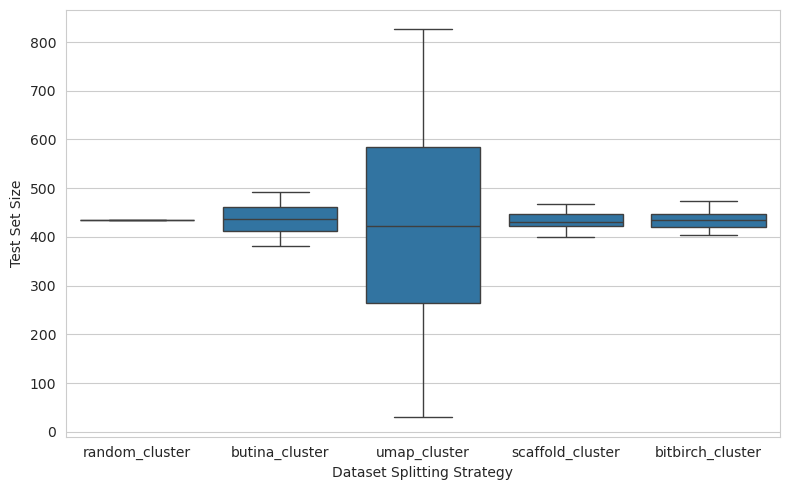

In [11]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
ax = sns.boxplot(x="split",y="num_test",data=result_df)
ax.set_xlabel("Dataset Splitting Strategy")
ax.set_ylabel("Test Set Size")
plt.tight_layout()
plt.show()

The variability in test set size with **umap_cluster** can be attributed to the variation in cluster sizes.  Some of this may be due to the fact that we're only using 7 clusters.  Let's examine the impact of the number of clusters from AgglomerativeClustering on the size of the test sets. 

In [12]:
urc_result_list = []
for num_clus in tqdm(range(5,76,5)):
    for i in range(0,5):
        cluster_list = uru.get_umap_clusters(size_df.SMILES,n_clusters=num_clus)
        group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        for train, test in group_kfold_shuffle.split(np.stack(size_df.fp),size_df.logS,cluster_list):
            urc_result_list.append([num_clus,len(test)])
urc_result_df = pd.DataFrame(urc_result_list,columns=["num_clus","num_test"])   

100%|██████████| 15/15 [01:17<00:00,  5.17s/it]


Looking at the plot below, the test set size seems to stabilize when we reach about 35 clusters. 

Text(0, 0.5, 'Number of Test Set Molecules')

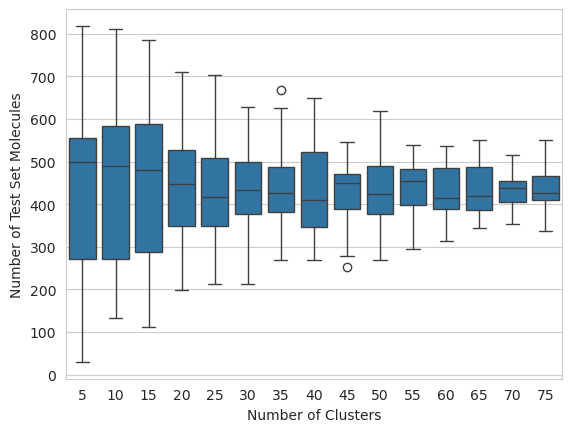

In [13]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="num_clus",y="num_test",data=urc_result_df)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Number of Test Set Molecules")

#### Make tSNE Plots to Compare the Data Splits 
We would like to generate a plot to visualize the training and test set distributions for our dataset using the different splitting methods.  To do this, we'll project the fingerprints into two dimensions using truncate stochastic neighbor embedding (tSNE).  

In [14]:
def get_tsne_coords(smiles_list):
    fp_gen = rdFingerprintGenerator.GetMorganGenerator()
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    fp_list = [fp_gen.GetFingerprintAsNumPy(x) for x in mol_list]   #Using binary fingerprints in this test
    pca = PCA(n_components=50)
    pcs = pca.fit_transform(fp_list)
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
    res = tsne.fit_transform(pcs)
    tsne_x = res[:,0]
    tsne_y = res[:,1]
    return tsne_x, tsne_y

Use **GroupKFoldShuffle** to split the dataset using each of methods we defined above.  Since this is simply a visual illustration, we'll only do one round of cross validation. 

In [15]:
split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster", "bitbirch_cluster"]
split_dict = {}
for split in split_list:
    kf = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(df,groups=df[split]):
        split_dict[split] = [train_idx, test_idx]
        break

Any cross validation method that splits a dataset based on clusters, won't produce the same test set size every time.  Let's look at the training and test set sizes. 

In [16]:
for k,v in split_dict.items():
    print(k,len(v[0]),len(v[1]))

random_cluster 1738 435
butina_cluster 1749 424
umap_cluster 1795 378
scaffold_cluster 1741 432
bitbirch_cluster 1764 409


Get tSNE 2D coordinates for the molecules and add them to the dataframe. 

In [17]:
tsne_x, tsne_y = get_tsne_coords(df.SMILES)

df['tsne_x'] = tsne_x
df['tsne_y'] = tsne_y

Create a new dataframe with the tSNE coordiantes. 

In [18]:
tmp_df = df[['tsne_x','tsne_y']].copy()
tmp_df.reset_index(inplace=True)

Add training and test set labels to **tmp_df** using the four splitting methods defined above. 

In [19]:
split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster", "bitbirch_cluster"]
for split in split_list:
    tmp_df[split] = "train"
    _, test_idx = split_dict[split]
    for t in test_idx:
        tmp_df[split].at[t] = "test"

Plot the chemical space of the dataset and show the training set in light blue and the test set in red.  To be honest, I don't see a large difference between the plots.  The only obvious difference is with **umap_cluster** where the test set is much more localized. 

In [20]:
tmp_df

,index,tsne_x,tsne_y,random_cluster,butina_cluster,umap_cluster,scaffold_cluster,bitbirch_cluster
0,0,11.749401,0.560243,train,train,train,test,train
1,1,6.294118,44.305431,train,test,train,test,train
2,2,-18.332075,0.492822,train,train,train,train,train
3,3,28.602287,-20.914253,train,train,train,train,train
4,4,24.047338,-43.549046,train,train,test,train,train
...,...,...,...,...,...,...,...,...
2168,2168,-9.486889,25.568024,train,train,train,train,train
2169,2169,-34.739124,-6.495655,train,test,train,test,train
2170,2170,-23.455921,-12.110656,train,train,train,train,test
2171,2171,11.954920,50.115593,train,test,train,test,train


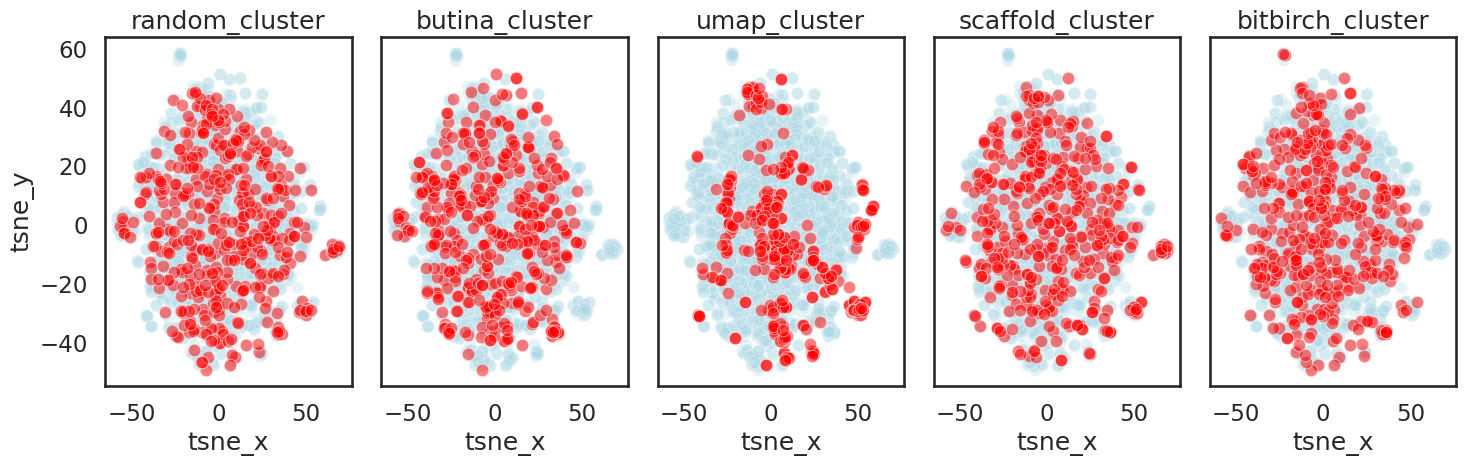

In [21]:
sns.set_style('white')
sns.set_context('talk')
figure, axes = plt.subplots(1,5, figsize=(15,5),sharey=True)
for i,split in enumerate(split_list):
    scatter_ax = sns.scatterplot(x="tsne_x",y="tsne_y",data=tmp_df.query(f"{split} == 'train'"),ax=axes[i],color="lightblue",                            
                                alpha=0.3, legend=False)
    sns.scatterplot(x="tsne_x",y="tsne_y",data=tmp_df.query(f"{split} == 'test'"),ax=axes[i],color="red",                            
                                alpha=0.5, legend=False)
    scatter_ax.set_title(split)
plt.tight_layout()

#### Calculate the Tanimoto Similarity Between the Training and Test Sets
The tSNE plots weren't very satisfying.  Instead, let's try another approach.  We will make box plots comparing the similarity to the 5 nearest training set neighbors for each test set molecule.  First we'll write a function to do the similarity calculations.

In [22]:
def train_test_tanimoto(train_smiles_list, test_smiles_list, top_n=5):
    fp_gen = rdFingerprintGenerator.GetMorganGenerator()
    train_mol_list = [Chem.MolFromSmiles(x) for x in train_smiles_list]
    train_fp_list = [fp_gen.GetFingerprint(x) for x in train_mol_list]     #Using binary fingerprints in this test
    test_mol_list = [Chem.MolFromSmiles(x) for x in test_smiles_list]
    test_fp_list = [fp_gen.GetFingerprint(x) for x in test_mol_list]
    result_list = []
    for test_fp in test_fp_list:
        sim_list = BulkTanimotoSimilarity(test_fp, train_fp_list)
        sim_array = np.array(sim_list)
        idx = np.argpartition(np.array(sim_array),-top_n)[-top_n:]
        best_n_tanimoto = sim_array[idx]
        result_list.append(best_n_tanimoto)    
    return np.array(result_list).flatten()

Perform 5x5-fold cross validation calculating the Tanimoto similarity between test set molecules and training set molecules. 

In [23]:
df_list = []
split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster", "bitbirch_cluster"]
for split in split_list:
    fold = 0
    idx = 0
    for i in tqdm(range(0,5),desc=split):
        kf = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        for train_idx, test_idx in kf.split(df,groups=df[split]):
            train = df.iloc[train_idx]
            test = df.iloc[test_idx] 
            sim_vals = train_test_tanimoto(train.SMILES, test.SMILES)
            idx = np.arange(0,len(sim_vals)) + fold*len(sim_vals)
            sim_df = pd.DataFrame({"sim" : sim_vals, "fold" : fold, "split" : split, "idx" : idx })
            fold += 1
            df_list.append(sim_df)

bitbirch_cluster: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Plot distributions of Tamimoto similarity for the 5 nearest neighbors for each test set molecule.  Only plot the first 10 cross-validation folds so the plot doesn't get overly crowded. 

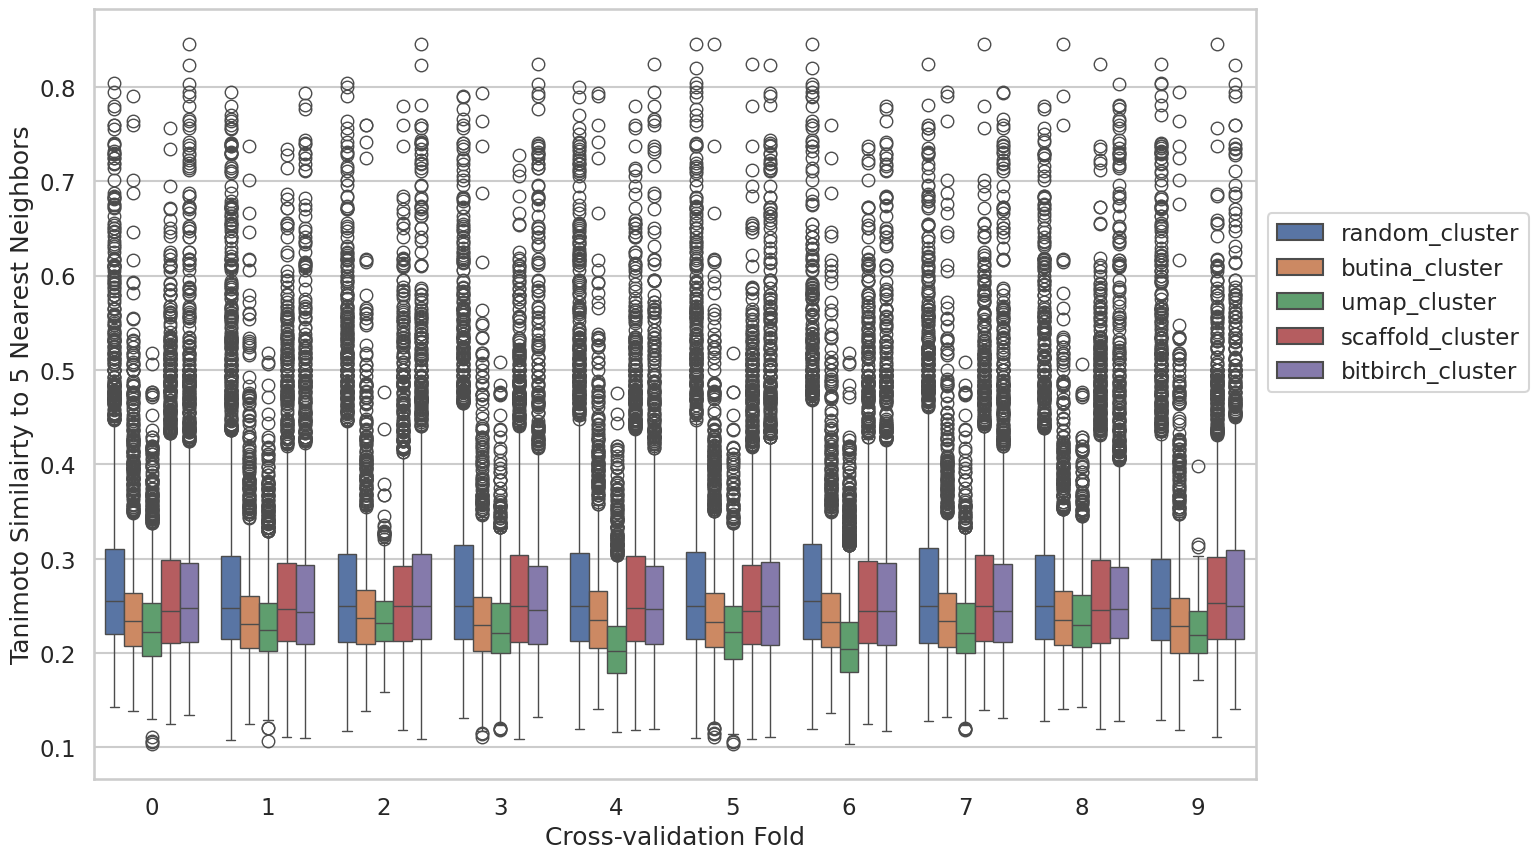

In [24]:
combo_df = pd.concat(df_list)
sns.set(rc={'figure.figsize' : (15,10)})
sns.set_style('whitegrid')
sns.set_context('talk')
ax = sns.boxplot(data=combo_df.query("fold < 10"),x="fold",y="sim",hue="split")
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)
ax.set_xlabel("Cross-validation Fold")
ax.set_ylabel("Tanimoto Similairty to 5 Nearest Neighbors");

Make boxplots of Tanimoto similarity of each test set molecule to its 5 nearest neighbors.  This is simply the plot above where all cross-validation fold are pooled. 

<Axes: xlabel='split', ylabel='sim'>

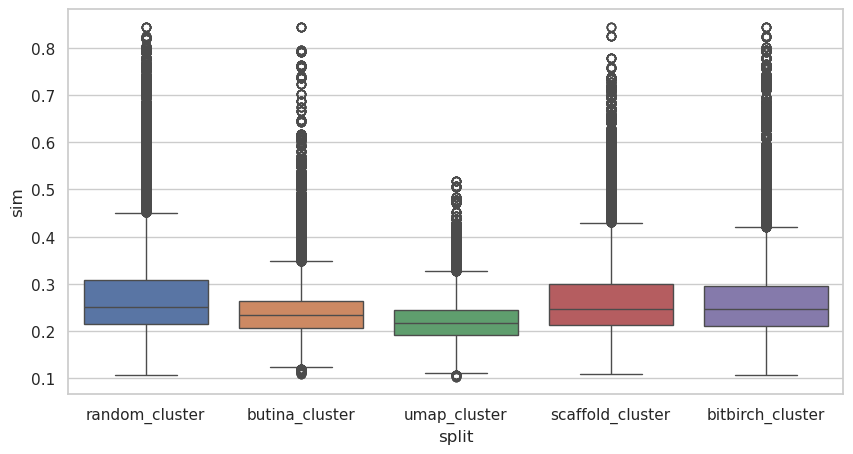

In [25]:
sns.set(rc={'figure.figsize' : (10,5)})
sns.set_style('whitegrid')
sns.boxplot(data=combo_df, x="split", y="sim", hue="split")

As stated by Walters, there is a "a strong correlation between model performance and the similarity of each test set molecule to its five nearest training set neighbors". **random_cluster**, **bitbirch_cluster** and **scaffold_cluster** provide more neighbors compared to the other methods. 

Use the Tukey Honestly Significant Difference (HSD) test to determine whether the differences between Tanimoto similairty distributions are signficant. 

In [26]:
tukey_res = pairwise_tukeyhsd(combo_df.sim, combo_df.split)

In [27]:
print(tukey_res)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
bitbirch_cluster   butina_cluster  -0.0256   0.0 -0.0269 -0.0242   True
bitbirch_cluster   random_cluster   0.0115   0.0  0.0101  0.0129   True
bitbirch_cluster scaffold_cluster   0.0013 0.059    -0.0  0.0027  False
bitbirch_cluster     umap_cluster  -0.0466   0.0 -0.0479 -0.0452   True
  butina_cluster   random_cluster    0.037   0.0  0.0357  0.0384   True
  butina_cluster scaffold_cluster   0.0269   0.0  0.0255  0.0283   True
  butina_cluster     umap_cluster   -0.021   0.0 -0.0224 -0.0196   True
  random_cluster scaffold_cluster  -0.0101   0.0 -0.0115 -0.0088   True
  random_cluster     umap_cluster  -0.0581   0.0 -0.0594 -0.0567   True
scaffold_cluster     umap_cluster  -0.0479   0.0 -0.0493 -0.0465   True
----------------------------------------------------------------

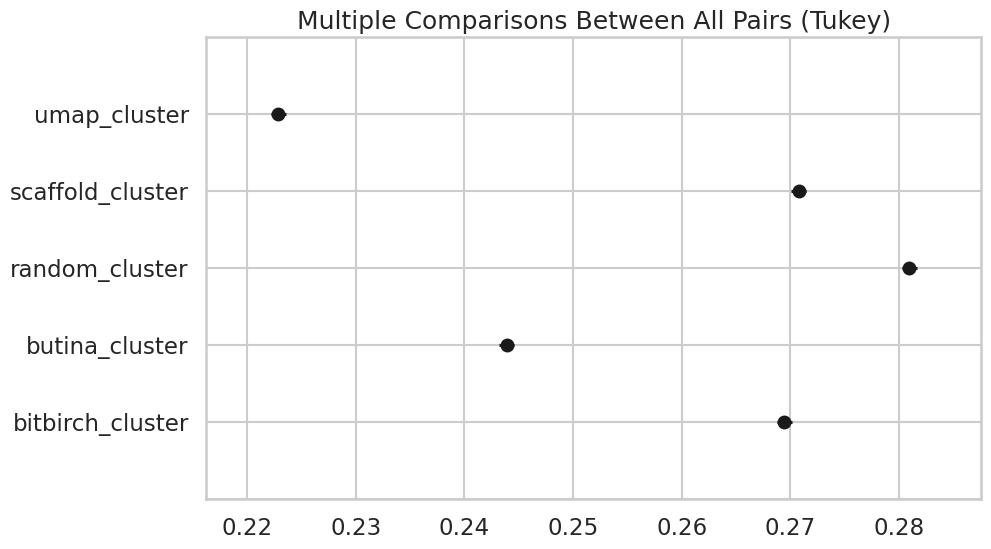

In [28]:
sns.set_style('whitegrid')
sns.set_context('talk')
_ = tukey_res.plot_simultaneous()

#### Examine the Impact of Dataset Splitting on ML Model Performance 
We've seen how the different splitting methods affect the similairty between the training and test sets.  Now let's see how the same splits impact model performance.  To do this, we will use the **cross_validate** function in useful_rdkit_utils.  To use the function we pass the following arguments. 
* An input dataframe, which must contain a SMILES column
* A list of tuples containing a model name and and instance of a wrapper class that runs a model. The wrapper class must support an **evaluate** function which takes dataframes containing training and test sets as input and returns a list of predictions for the test set.
* The name of the **y** variable in the dataframe
* A list of tuples containing a name and a function to group the data.  These groups will be passed to an instance of **GroupKFoldShuffle**
* The number of outer cross-validation folds
* The number of inner cross-validation folds

While this may sound complicated, it's actually simple.  The code block below defines the model list, the group list, and the y column. We are comparing 
* one model - LightGBM
* five splitting methods - butina, random, scaffold, bitbirch, and umap
  
The **y** column in the dataset is **logS**.  That's it. 

In [29]:
model_list = [("lgbm_morgan", LGBMMorganCountWrapper)]
group_list = [("butina", uru.get_butina_clusters), ("random", uru.get_random_clusters),
              ("scaffold", uru.get_bemis_murcko_clusters), ("umap", uru.get_umap_clusters),
              ("bitbirch", get_bitbirch_clusters)]
y = "logS"

With the definitions above, call **cross_validate**, which returns a dataframe with the training and test sets for each fold, as well as the predicted values. 

In [30]:
result_df = uru.cross_validate(df, model_list, y, group_list, 5, 5)
outfile_name = "biogen_logS_results.csv"
result_df.to_csv(outfile_name, index=False)

butina: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]
                                                     
random: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]
                                                     
scaffold: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
                                                       
umap: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]
                                                   
butina: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]
                                                     
random: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                                                     
scaffold: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
                                                       
umap: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]
                                                   
butina: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]
                                                     
random: 100%|██████████| 5/5

Now, we'll calculate some statistics on the dataset.  To do this, we only need the data from the test set. 

In [31]:
test_df = result_df.query("dset == 'test'")

Collect the data from the cross-validation folds and calculate $R^2$ for each fold.  This will give us a distribution of $R^2$ values for each splitting method. 

In [32]:
out_list = []
for k,v in test_df.groupby(["group","fold"]):
    group, fold = k
    r2 = r2_score(v.logS,v.lgbm_morgan)
    out_list.append([group, fold, r2])
out_df = pd.DataFrame(out_list,columns=["split","fold","r2"])

In [33]:
out_df

,split,fold,r2
0,bitbirch,0,0.318144
1,bitbirch,1,0.332527
2,bitbirch,2,0.358442
3,bitbirch,3,0.346443
4,bitbirch,4,0.335413
...,...,...,...
120,umap,20,0.315700
121,umap,21,0.009773
122,umap,22,0.263458
123,umap,23,0.319726


Plot a boxplot showing the $R^2$ distributions for each splitting method. 

Text(0.5, 0, 'Split')

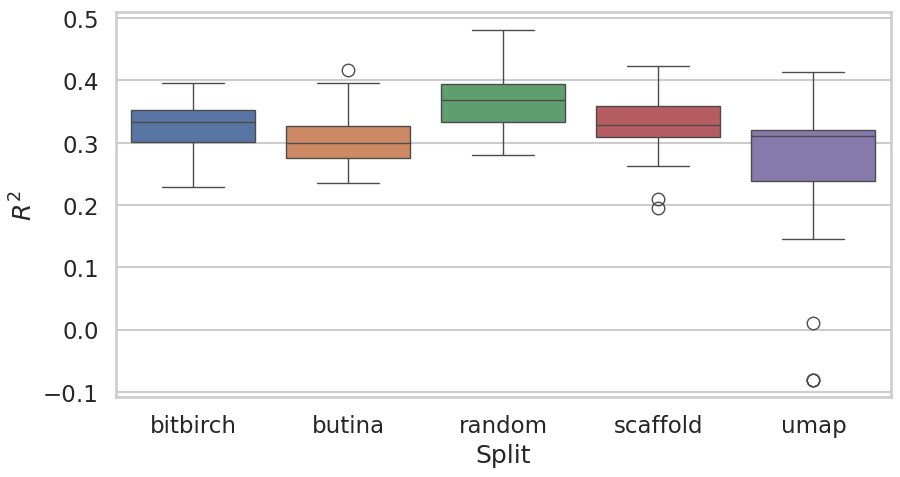

In [34]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="split",y="r2",hue="split",data=out_df)
ax.set_ylabel("$R^2$")
ax.set_xlabel("Split")

From the plot above, it's clear that the **umap** splits are the most challenging for the model.  The $R^2$ distributions for the **bitbirch** split and the **random** split appear similar, generating models with higher $R^2$ values. We can use the Tukey HSD test to determine whether statistically significant differences exist between the splitting methods.  The table **tukey_res** table below shows the following. 
* **group1** - the first split being compared
* **group2** - the second split being compared
* **meandiff** - the mean difference between the two splitting methods
* **p-adj** - the p-value for the difference between distributions, corrected for multiple comparisons
* **lower** - the lower bound of the confidence interval
* **upper** - the upper bound of thhe confidence interval
* **reject** - can we reject the null hypothesis that the means of the distributions are the same

In [35]:
tukey_res = pairwise_tukeyhsd(out_df.r2, out_df.split)

In [36]:
print(tukey_res)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
bitbirch   butina  -0.0197 0.8988 -0.0809  0.0414  False
bitbirch   random   0.0386 0.4088 -0.0226  0.0997  False
bitbirch scaffold   0.0012    1.0   -0.06  0.0623  False
bitbirch     umap  -0.0851 0.0017 -0.1462 -0.0239   True
  butina   random   0.0583 0.0693 -0.0028  0.1195  False
  butina scaffold   0.0209  0.878 -0.0402  0.0821  False
  butina     umap  -0.0653 0.0299 -0.1265 -0.0042   True
  random scaffold  -0.0374  0.441 -0.0986  0.0237  False
  random     umap  -0.1237    0.0 -0.1848 -0.0625   True
scaffold     umap  -0.0862 0.0014 -0.1474 -0.0251   True
--------------------------------------------------------


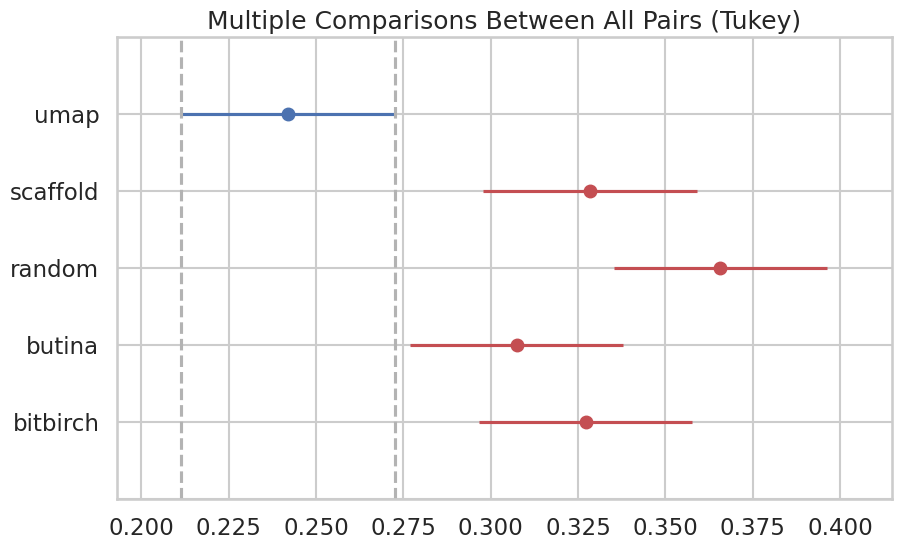

In [37]:
sns.set_style('whitegrid')
sns.set_context('talk')
_ = tukey_res.plot_simultaneous(comparison_name="umap")

## Compare BitBIRCH and Butina Timing

We would like to see how the speed of **BitBIRCH** compares to that of **Butina**. We want to only compare the clustering method itself, without having to account for the fingerprint computation. Now that we have stored fingerprints in size_df, we will do a quick comparison of the two methods. 

In [38]:
def numpy_to_explicit_bitvect(fp):
    bitvect = ExplicitBitVect(len(fp))  
    for idx, val in enumerate(fp):
        if val:  
            bitvect.SetBit(idx)
    return bitvect

#### Comparison with biogen data (2173 total molecules)

In [39]:
data = np.array(size_df.binary_fps.values.tolist())

# rdkit_fp_list = [fpgen.GetFingerprint(mol) for mol in size_df.mol.values]
rdkit_fp_list = [numpy_to_explicit_bitvect(fp) for fp in data]

In [40]:
s_time = time.time()
bitbirch = bb.BitBirch(branching_factor=50, threshold=0.65)  
bitbirch.fit(data)
bitbirch_time = time.time() - s_time
print('Time for BitBIRCH Clustering (s):', bitbirch_time)

dists = []
nfps = len(rdkit_fp_list)
s_time = time.time()
for i in range(1, nfps):
    sims = BulkTanimotoSimilarity(rdkit_fp_list[i], rdkit_fp_list[:i])
    dists.extend([1 - x for x in sims])
cluster_res = Butina.ClusterData(dists, nfps, 0.65, isDistData=True)
butina_time = time.time() - s_time
print('Time for Butina Clustering (s):', butina_time)


Time for BitBIRCH Clustering (s): 0.4019613265991211
Time for Butina Clustering (s): 0.4210681915283203


We see on the biogen dataset, of 2173 structures, **BitBIRCH** performs slightly faster than **Butina**, although they are very similar. Let's see how the two methods compare on a larger dataset. 

#### Comparison with sample of the Chembl library (20,000 total molecules)

In [41]:
chembl_fps = np.load('chembl_20Ksample_fps.npy')

chembl_rdkit_fp_list = [numpy_to_explicit_bitvect(fp) for fp in chembl_fps]

In [42]:
s_time = time.time()
bitbirch = bb.BitBirch(branching_factor=50, threshold=0.65)  
bitbirch.fit(chembl_fps)
bitbirch_time = time.time() - s_time
print('Time for BitBIRCH Clustering (s):', bitbirch_time)


dists = []
# cutoff = 0.65
nfps = len(chembl_rdkit_fp_list)
s_time = time.time()
for i in range(1, nfps):
    sims = BulkTanimotoSimilarity(chembl_rdkit_fp_list[i], chembl_rdkit_fp_list[:i])
    dists.extend([1 - x for x in sims])
cluster_res = Butina.ClusterData(dists, nfps, 0.65, isDistData=True)
butina_time = time.time() - s_time
print('Time for Butina Clustering (s):', butina_time)

/home/kdavis2/notebook_workflow/splitting_personal/bitbirch.py:279: RuntimeWarning: invalid value encountered in divide
  sim_matrix = a / (np.sum(self.centroids_, axis = 1) + set_bits - a)
/home/kdavis2/notebook_workflow/splitting_personal/bitbirch.py:51: RuntimeWarning: invalid value encountered in scalar divide
  return a/(a + n_objects * sum_kq - sum_kqsq)


Time for BitBIRCH Clustering (s): 3.7092125415802
Time for Butina Clustering (s): 37.512155294418335


We see that BitBIRCH out performs Butina in regards to speed on a dataset of 20K structures. 